Use Haldane's mapping function to estimate recombination rate (c) between the two ends on msprime simulated genome. Two completely unlinked loci would have c=0.5.

In [1]:
r=3.75e-8 # Recombination rate per base per generation
y=1e6 # Sequence length
c=0.5*(1-(1-2*r)^y)
c

[1] 0.03612826

# Plot overall LD values

Could choose to inspect a few scenarios by reading different csv files. 

In [3]:
df <- read.csv("../data/LD/sd6_300_merged.csv")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


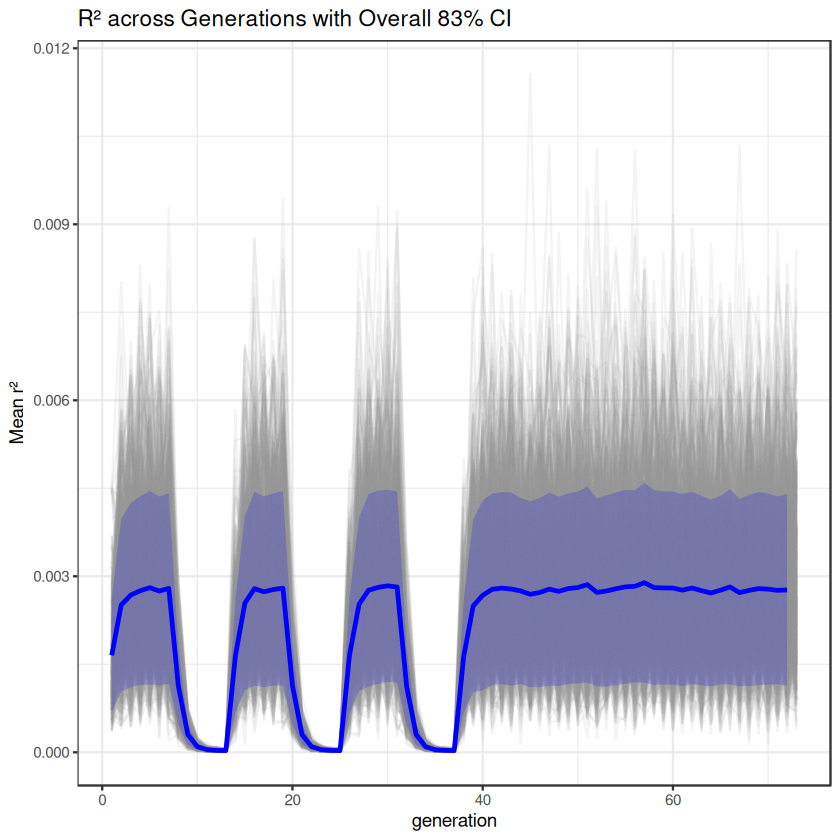

In [4]:
library(ggplot2)
library(dplyr)
library(patchwork)


# Calculate overall mean and CI of r² for each generation
r2_summary <- df %>%
  group_by(generation) %>%
  summarise(
    mean_r2 = mean(mean_r2),
    lower_overall = mean(lower_ci),
    upper_overall = mean(upper_ci)
  )


plot_r2 <- ggplot() +
  # Plot all replicates
  geom_line(data = df, aes(x = generation, y = mean_r2, group = seed), 
            alpha = 0.1, color = "gray60") +
  # Overall mean line
  geom_line(data = r2_summary, aes(x = generation, y = mean_r2), 
            color = "blue", linewidth = 1) +
  # Overall CI ribbon
  geom_ribbon(data = r2_summary, 
              aes(x = generation, ymin = lower_overall, ymax = upper_overall),
              fill = "blue", alpha = 0.2) +
  labs(title = "R² across Generations with Overall 83% CI",
       y = "Mean r²") +
  theme_bw()


print(plot_r2)

# Plot the power curves

In [5]:
# Read the constant setting data
df1 <- read.csv("../data/LD/con_merged.csv")
df2 <- read.csv("../data/LD/dec300_merged.csv")
df3 <- read.csv("../data/LD/dec3000_merged.csv")

In [6]:
##### Power Analysis #####
library(dplyr)
library(ggplot2)

# Calculate the proportion of non-overlapping CIs between pre- and post-decline generations
process_df <- function(df, label) {
  pre_data <- df %>% filter(generation == 33)
  post_data <- df %>% filter(generation > 37)
  
  result <- post_data %>%
    left_join(pre_data, by = "seed", suffix = c("_post", "_pre")) %>%
    mutate(no_overlap = upper_ci_post < lower_ci_pre | lower_ci_post > upper_ci_pre) %>%
    group_by(generation_post) %>%
    summarise(
      non_overlap_ratio = mean(no_overlap),
      total_replicates = n(),
      .groups = "drop"
    ) %>%
    rename(generation = generation_post) %>%
    arrange(generation) %>%
    mutate(dataset = label)
  
  return(result)
}

res1 <- process_df(df1, "Constant")
res2 <- process_df(df2, "99% Decline")
res3 <- process_df(df3, "90% Decline")

all_results <- bind_rows(res1, res2, res3)


Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


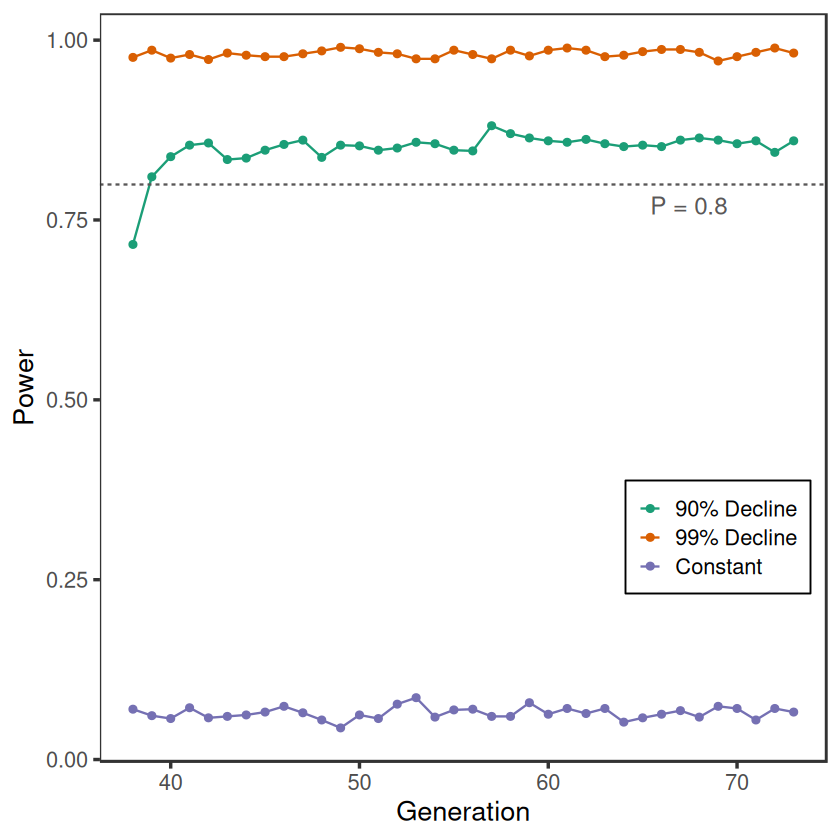

In [7]:
p1 <- ggplot(all_results, aes(x = generation, y = non_overlap_ratio, color = dataset)) +
      geom_line() +
      geom_point() +
      scale_y_continuous() +
      scale_color_brewer(palette = "Dark2") +

      labs(x = "Generation", y = "Power",
            color = NULL) +
      theme_bw(base_size = 16) +
      theme(
      legend.position = c(0.85, 0.3),
      legend.box = "vertical",
      legend.spacing.y = unit(0.3, "cm"),
      legend.title = element_text(face = "bold"),
      legend.key.width = unit(0.5, "cm"),
      legend.background = element_rect(
      fill = "white", 
      color = "black", 
      linewidth = 0.4
    ),
      panel.grid.minor = element_blank(),
      panel.grid.major = element_blank()
      )

p1 <- p1 + 
  geom_hline(yintercept = 0.8, linetype = "dashed", color = "#595757")+
	annotate("text", x = 65, y = 0.77, label = "P = 0.8", color = "#595757", hjust = -0.1, size=5)


p1

In [8]:
ggsave(p1, filename = "../outputs/combined_plots/LD_constant.pdf", width = 7, height = 7)

In [9]:
# Seasonal data
df4 <- read.csv("../data/LD/s3_merged.csv")
df5 <- read.csv("../data/LD/s6_merged.csv")
df6 <- read.csv("../data/LD/sd3_300_merged.csv")
df7 <- read.csv("../data/LD/sd3_3000_merged.csv")
df8 <- read.csv("../data/LD/sd6_300_merged.csv")
df9 <- read.csv("../data/LD/sd6_3000_merged.csv")

In [17]:
##### Power Analysis #####
library(dplyr)
library(ggplot2)
library(patchwork)

# Define pre-generation list
pre_list <- c(22, 25, 28, 31, 34)

# Calculate power from multiple pre-generations
process_df_multi_pre <- function(df, label, pre_list) {
  results <- lapply(pre_list, function(pre) {
    pre_data <- df %>% filter(generation == pre)
    post_data <- df %>% filter(generation > 36)
    
    res <- post_data %>%
      left_join(pre_data, by = "seed", suffix = c("_post", "_pre")) %>%
      mutate(no_overlap = upper_ci_post < lower_ci_pre | lower_ci_post > upper_ci_pre) %>%
      group_by(generation_post) %>%
      summarise(
        non_overlap_ratio = mean(no_overlap),
        total_replicates = n(),
        .groups = "drop"
      ) %>%
      rename(generation = generation_post) %>%
      arrange(generation) %>%
      mutate(pre_generation = pre, dataset = label)
    
    return(res)
  })
  
  bind_rows(results)
}

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”


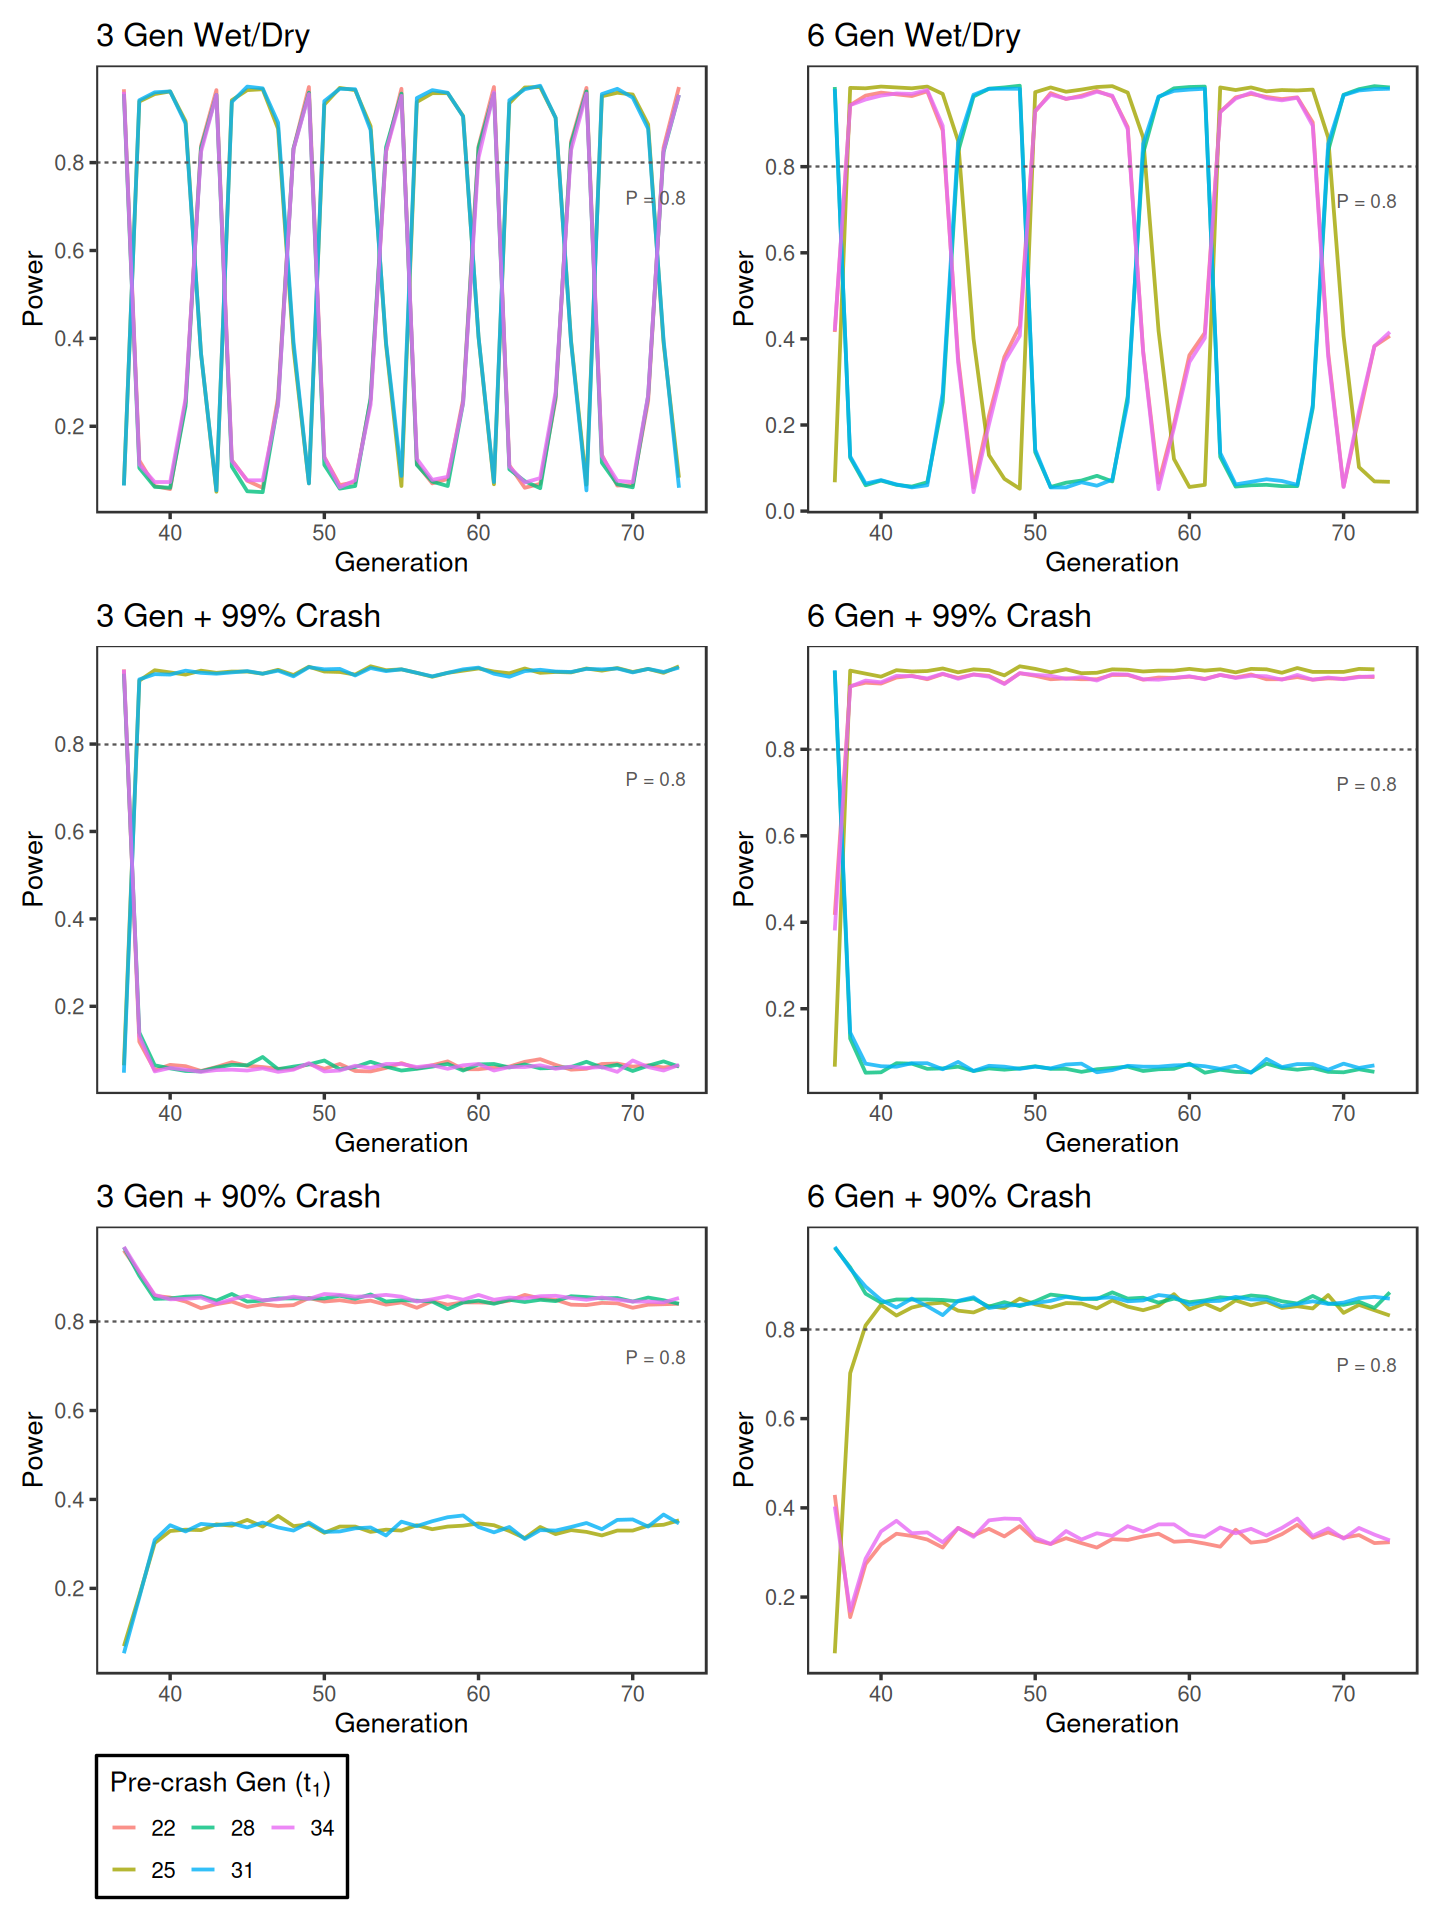

In [18]:
# Plotting for one dataset
plot_df <- function(result, label) {
  ggplot(result, aes(x = generation, y = non_overlap_ratio,
                     color = factor(pre_generation))) +
    geom_line(size = 0.8, alpha = 0.8) +
    scale_y_continuous(
      breaks = seq(0, 0.8, by = 0.2)
    ) +
    labs(x = "Generation", y = "Power",
         color = expression("Pre-crash Gen (" * t[1] * ")"),
         title = label) +
    geom_hline(yintercept = 0.8, linetype = "dashed", color = "#595757") +
    annotate("text", x = 71.5, y = 0.72, label="P = 0.8", color="#595757") +
    theme_bw(base_size = 16) +
    theme(
      legend.position = "right",
      legend.justification = "center",
      panel.grid.minor = element_blank(),
      panel.grid.major = element_blank()
    ) +
    guides(
    color = guide_legend(
      override.aes = list(size = 3),
      ncol = 3,
      title.position = "top"
    )
  )
}


# Process all 6 datasets
res4 <- process_df_multi_pre(df4, "s3", pre_list)
res5 <- process_df_multi_pre(df5, "s6", pre_list)
res6 <- process_df_multi_pre(df6, "sd3_300", pre_list)
res7 <- process_df_multi_pre(df7, "sd3_3000", pre_list)
res8 <- process_df_multi_pre(df8, "sd6_300", pre_list)
res9 <- process_df_multi_pre(df9, "sd6_3000", pre_list)

p4 <- plot_df(res4, "3 Gen Wet/Dry")
p5 <- plot_df(res5, "6 Gen Wet/Dry")
p6 <- plot_df(res6, "3 Gen + 99% Crash")
p7 <- plot_df(res7, "3 Gen + 90% Crash")
p8 <- plot_df(res8, "6 Gen + 99% Crash")
p9 <- plot_df(res9, "6 Gen + 90% Crash")

# Combine plots with common legend
final_plot <- (p4 | p5) / (p6 | p8) / (p7 | p9) +
  plot_layout(guides = "collect", heights = c(1.2, 1.2, 1.2)) & 
  theme(
  legend.position = "bottom",
  legend.justification = "left",
  legend.background = element_rect(fill = "white", color = "black")
)


options(repr.plot.width = 12, repr.plot.height = 16)
final_plot

In [12]:
ggsave("../outputs/combined_plots/LD_seasonal.pdf", final_plot, width = 12, height = 16)

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”
